<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_5_3__Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks
## (Dive into Deep Learning https://d2l.ai/chapter_convolutional-neural-networks/index.html)

* The material for this notebook is mainly from the Open Source book -- Dive into Deep Learning. I have adapted a few things for the Computer Vision course at the University of South Florida, Tampa.

* Some figures are from Richard Szeliski's vision textbook for this course.

* We will use the nice visualizations at https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks

# Topics covered

* You will learn about a particular class of neural networks for images called the convolutional neural network.

* You will learn and implement the first commercially successful neural network for computer vision that reads numbers on the address block of letters – **the LeNet**, long before the rise of modern deep learning.

* You will learn how to use GPUs on Colab for training

**Concepts Learned:** CNN, padding, stride, pooling, channels, Multiple input and multiple output layer, 1 by 1 convolution, Adam optimizer

## Code: setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
!pip install d2l==0.16.2

# Convolutional Layers

* Appropriate for images, although CNNs are also useful in other contexts.

* Allows us to exploit the 2D pixel arrangement structure.
    * We do **not** have to **flatten** the image into a vector.

* Recall the use of image **convolutions** to detect edges and features.
    * A filter is placed at the image location, then we multiply and add.
    * See  https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks for a visualization
    * **Translation equivariance**: If you translate the image, you also translate the output.

  $$ f (x + a, y + b) \star h(x, y) = (f \star h) (x + a, y + b)$$
    * Technically, a convolutional layer **cross-correlates** the input and the kernel and adds a scalar bias to produce an output. It does not do convolutions, strictly speaking.


* We can also look at this computation as a **linear** neural network operation.
    * Each output is **not** connected to all the input indices but only to the local ones.
    * The weights are all the same for all the outputs.

* CNNs require fewer parameters than fully connected architectures; CNNs are easy to parallelize across GPU cores.

* The two essential parameters of a convolutional layer are the kernel and the scalar bias.

* When training models based on convolutional layers, we initialize the kernels randomly, just as we would with a fully connected layer.

* As defined in PyTorch, **each layer can process one mini-batch in one shot.**

* The convolutional blocks expects a 4-dimensional input and also outputs a 4-dimensional tensor with shape given by **(batch size, number of channels, height, width)**


## Code: Toy convolution




In [2]:
X = torch.ones((1, 1, 6, 8)) # batch size=1, number of channel=1.
X[0, 0, :, 2:6] = 0
print('Input (X)=\n', X)

K = torch.tensor([[[[1.0, -1.0]]]])
print('Kernel (K)=\n', K)

#---------------------Convolutional Layer-------------------------------------
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,2), bias=False)
conv2d.weight.data = K
#-----------------------------------------------------------------------------
Y = conv2d(X)
print('Y=\n', Y)

Input (X)=
 tensor([[[[1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.],
          [1., 1., 0., 0., 0., 0., 1., 1.]]]])
Kernel (K)=
 tensor([[[[ 1., -1.]]]])
Y=
 tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]],
       grad_fn=<ConvolutionBackward0>)


# Learning a Kernel

* The convolution layer above is essentially computing the **edge** by finite differences `[1, -1]`.

* Now let us see whether we can **learn the kernel that generated `Y` from `X`**
by looking at the input-output pairs only.

* We first construct a convolutional layer and initialize its kernel as a random tensor.

* Next, in each iteration, we will use the squared error to compare `Y` with the output of the convolutional layer.

* We can then calculate the gradient to update the kernel.



## Code: Toy kernel learning

In [3]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.Conv2d( 1, 1, kernel_size=(1, 2), bias=False)
print('Initial weight matrix (shape, value)\n', conv2d.weight.data.shape, '\n', conv2d.weight.data)
# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1

X = X.clone().detach().requires_grad_(False) # defined in the previous cell above
Y = Y.clone().detach().requires_grad_(False)
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = ((Y_hat - Y)**2).sum()
    l.backward() # compute gradients
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    conv2d.zero_grad()
    print(f'batch {i + 1}, loss {l.sum():.3f}, weight: {conv2d.weight.data}');




Initial weight matrix (shape, value)
 torch.Size([1, 1, 1, 2]) 
 tensor([[[[-0.1816,  0.3418]]]])
batch 1, loss 19.487, weight: tensor([[[[ 0.1285, -0.2566]]]])
batch 2, loss 8.071, weight: tensor([[[[ 0.5344, -0.4320]]]])
batch 3, loss 3.362, weight: tensor([[[[ 0.6283, -0.7102]]]])
batch 4, loss 1.414, weight: tensor([[[[ 0.8211, -0.7555]]]])
batch 5, loss 0.602, weight: tensor([[[[ 0.8383, -0.8908]]]])
batch 6, loss 0.262, weight: tensor([[[[ 0.9343, -0.8923]]]])
batch 7, loss 0.117, weight: tensor([[[[ 0.9277, -0.9613]]]])
batch 8, loss 0.054, weight: tensor([[[[ 0.9779, -0.9511]]]])
batch 9, loss 0.026, weight: tensor([[[[ 0.9665, -0.9880]]]])
batch 10, loss 0.013, weight: tensor([[[[ 0.9940, -0.9769]]]])


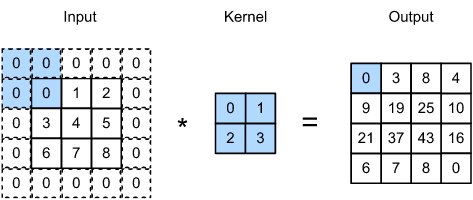

# Padding

* What to do for convolutions with border pixels?

* If we insist on not computing the convolution for border pixels, our output will be smaller than the input.

* One straightforward solution to this problem is to add extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image.
    * Typically, we set the values of the extra pixels to zero.

* See https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks for a visualization

* CNNs commonly use convolution kernels with odd height and width values, such as 1, 3, 5, or 7. Choosing odd kernel sizes is beneficial because we can preserve the spatial dimensionality while padding with the same number of rows on top and bottom and the same number of columns on left and right.


In [4]:
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3))
X = torch.rand(size=(1, 1, 8, 8))
print('Input size:', X.shape)
print('Output size (without padding):', conv2d(X).shape)

conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
X = torch.rand(size=(1, 1, 8, 8))
print('Output size (with padding):', conv2d(X).shape)

Input size: torch.Size([1, 1, 8, 8])
Output size (without padding): torch.Size([1, 1, 4, 6])
Output size (with padding): torch.Size([1, 1, 8, 8])


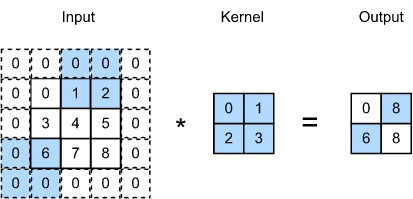

The above figure depicts cross-correlation with strides of 3 and 2 for height and width, respectively.

# Stride

* We start with the convolution window at the upper-left corner of the input tensor and then slide it over all locations down and to the right.

* See https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks for a visualization

* In previous examples, we default to sliding by one element at a time.
However, sometimes, either for computational efficiency
or because we wish to downsample,
we move our window more than one element at a time,
skipping the intermediate locations.

* We refer to the number of rows and columns traversed per slide as the *stride*.


* We can see that when the second element of the first column is output,
the convolution window slides down three rows.
The convolution window slides two columns to the right
when the second element of the first row is output.


In [5]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(1, 2), stride=(3, 3))

print('Input size:', X.shape)
print('Output size (with padding):', conv2d(X).shape)

Input size: torch.Size([1, 1, 8, 8])
Output size (with padding): torch.Size([1, 1, 3, 3])


# Multiple Input and Multiple Output Channels


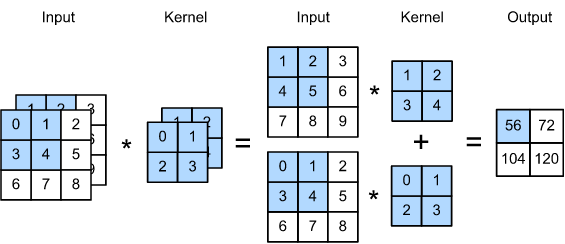

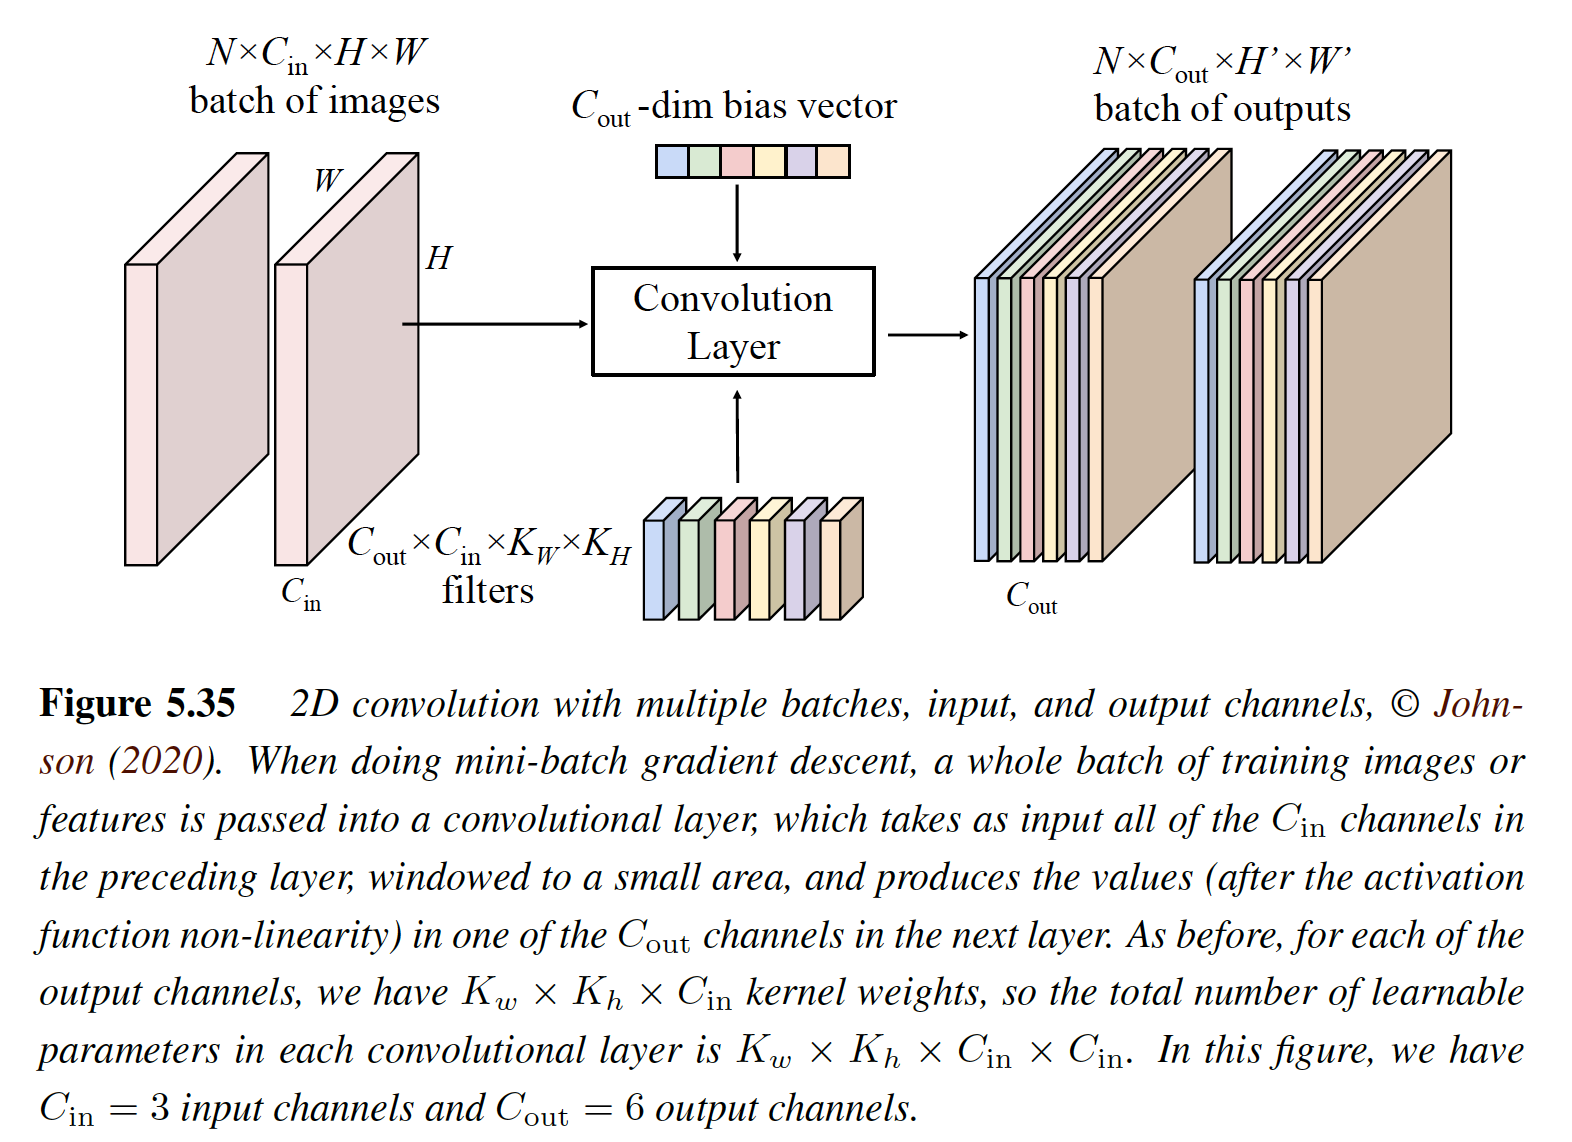

The above figure is from the textbook Computer Vision: Algorithms and Applications 2nd Edition Richard Szeliski - (c) 2022 Springer

# 1×1 Convolutional Layer

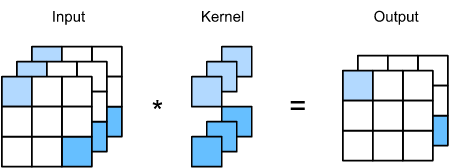

# Max pooling layer

* Maximum pooling with a pooling window shape of 2×2. The shaded portions are the first output element as well as the input tensor elements used for the output computation: max(0,1,3,4)=4.

* Contracts the size of the layer

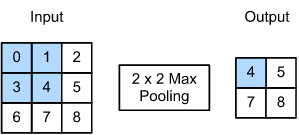

# LeNet

* We will introduce *LeNet*, among the first published CNNs to capture wide attention for its performance on computer vision tasks. The model was introduced by (and named for) Yann LeCun, then a researcher at AT&T Bell Labs, to recognize handwritten digits in images. This work represented the culmination of a decade of research developing the technology. In 1989, LeCun published the first study to train CNNs via backpropagation successfully.

* LeNet was eventually adapted to recognize digits for processing deposits in ATMs. Some ATMs still run the code Yann and his colleague Leon Bottou wrote in the 1990s!

* The architecture is summarized in the picture below. At a high level, (**LeNet**) (LeNet-5) consists of two parts:
    1. a convolutional encoder consisting of two convolutional layers; and
    2. a dense block consisting of three fully-connected layers;
    3. The input is a handwritten digit, and the output is a probability over 10 possible outcomes.



* The basic units in each convolutional block are a convolutional layer with $5\times 5$ kernel, a sigmoid activation function, and a subsequent average pooling operation.
    * Note that while ReLUs and max-pooling work better, these discoveries were not made in the 1990s.

* The first convolutional layer has 6 output channels, while the second has 16.

* Each $2\times2$ pooling operation (stride 2) reduces dimensionality by a factor of $4$ via spatial downsampling.

* The convolutional block emits an output with shape (batch size, number of channels, height, width).

* To pass output from the convolutional block to the dense block, we must flatten each example in the minibatch.
    * In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully-connected layers. Note nn.flatten flattens the dimensions 1 through -1 (last one) by default; it leave the first dimension for channels alone.

* LeNet's dense block has three fully connected layers, with 120, 84, and 10 outputs, respectively. Because we are still performing classification, the 10-dimensional output layer corresponds to the number of possible output classes.


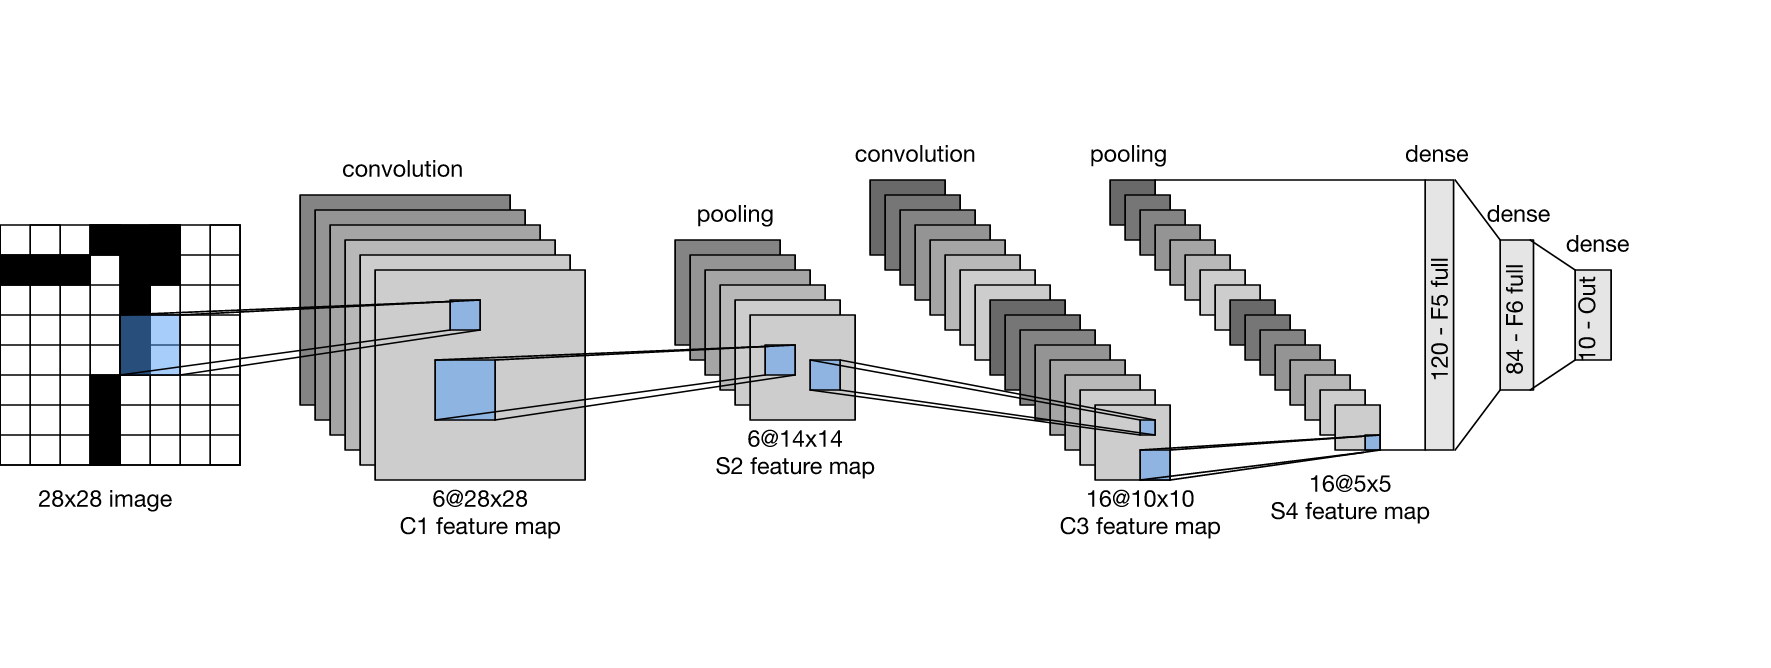

## Code: LeNet

In [6]:
import torch
from torch import nn

net = nn.Sequential(# First convolution layer
                    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
                    nn.Sigmoid(), #activation layer
                    nn.AvgPool2d(kernel_size=2, stride=2),

                    # Second convolution layer
                    nn.Conv2d(6, 16, kernel_size=5),
                    nn.Sigmoid(), #activation layer
                    nn.AvgPool2d(kernel_size=2, stride=2),

                    # Third fully connected (FC) layer
                    nn.Flatten(),
                    nn.Linear(16 * 5 * 5, 120),
                    nn.Sigmoid(),

                    # Fourth fully connected (FC) layer
                    nn.Linear(120, 84),
                    nn.Sigmoid(),

                    # Fifth fully connected (FC) layer
                    nn.Linear(84, 10))

* By passing a single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can **inspect the model** to make sure
that its operations line up with
what we expect.

In [7]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Total parameters:', total_params)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Total parameters: 61706
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


* Note that the height and width of the representation
at each layer throughout the convolutional block
is reduced (compared with the previous layer).

* The first convolutional layer uses 2 pixels of padding
to compensate for the reduction in height and width
that would otherwise result from using a $5 \times 5$ kernel.

* In contrast, the second convolutional layer forgoes padding,
and thus, the height and width are both reduced by 4 pixels.

* As we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second convolutional layer.

* However, each pooling layer halves the height and width.

* Finally, each fully-connected layer reduces dimensionality,
finally emitting an output whose dimension
matches the number of classes.

##Code (support): `Animator` class

In [8]:
from IPython import display
from d2l import torch as d2l

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(10, 10)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []

        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n  #repeat x axis values n times, one for each plot
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## Code (support): `Accumulator`



In [9]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # creates [0.0, 0.0, ....n-times]

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # Example: let self.data = [10, 15] and args be [3, 4]
        # zip(self.data, args) will produce the paired iterable [(10, 3), (15, 4)]
        # the for loop with go over these paired entries adding them up to result in [13, 19]

    def reset(self):
        self.data = [0.0] * len(self.data) # creates [0.0, 0.0, ....n-times]

    def __getitem__(self, idx):
        return self.data[idx]

## Code (support): `evaluate_accuracy`

In [10]:
def accuracy (y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: #The output is a vector -- not just a scalar
        y_hat = y_hat.argmax(axis=1)
    cmp = (y_hat.type(y.dtype) == y)
    return float(cmp.type(y.dtype).sum())

In [11]:
def evaluate_accuracy (net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions

    with torch.no_grad():
        for X, y in data_iter: # iterate over the minibatches
            X, y = X.to(device), y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## Code: Fashion MNIST data

Note: We are accessing the dataset directly from torch vision, unlike via d2l in a pervious lecture.

# of minibatches each of size 64 
	 in training data:938, 
	 testing data: 157


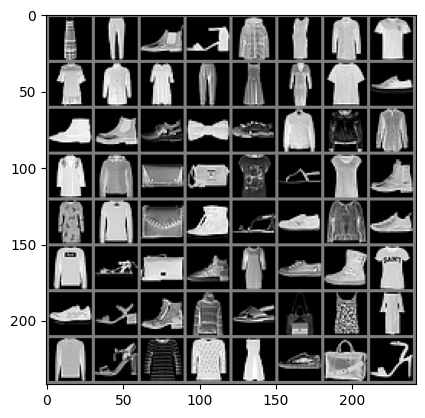

Dress Trouser Ankle boot Sandal  Coat Dress  Coat T-shirt Dress  Coat Dress Trouser Dress Dress Shirt Sneaker Ankle boot Ankle boot Sneaker   Bag Sandal  Coat  Coat Shirt  Coat  Coat   Bag   Bag Shirt Sandal T-shirt Ankle boot Dress Pullover   Bag Ankle boot Sandal Sneaker Shirt Sneaker Pullover Sandal   Bag Sneaker Dress Sneaker Ankle boot T-shirt Sneaker Sandal Ankle boot  Coat Sandal   Bag T-shirt Dress Pullover Sandal Pullover Pullover Dress Sneaker   Bag Sandal
tensor([3, 1, 9, 5, 4, 3, 4, 0, 3, 4, 3, 1, 3, 3, 6, 7, 9, 9, 7, 8, 5, 4, 4, 6,
        4, 4, 8, 8, 6, 5, 0, 9, 3, 2, 8, 9, 5, 7, 6, 7, 2, 5, 8, 7, 3, 7, 9, 0,
        7, 5, 9, 4, 5, 8, 0, 3, 2, 5, 2, 2, 3, 7, 8, 5])


In [12]:
import torchvision.transforms as transforms

FashionMNIST_classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                        'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
transform_FashionMNIST = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
batch_size = 64

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform_FashionMNIST)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform_FashionMNIST)


train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


print('# of minibatches each of size %d \n\t in training data:%d, \n\t testing data: %d'%(batch_size, len(train_iter), len(test_iter)))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #reorder into (row, col, color)
    plt.show()


# get some random training images
images, labels = next(iter(train_iter))

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % FashionMNIST_classes[labels[j]] for j in range(batch_size)))
print(labels)




## Code: `train_full`

In [13]:
#-------------------------------------------------------------------------------
import time
def train_one_epoch (net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
            X, y = X.to(device), y.to(device) # Move data to device - GPU or CPU as set
            # Compute gradients and update parameters
            y_hat = net(X)
            l = loss(y_hat, y)

            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

#-------------------------------------------------------------------------------
def train_full (net, train_iter, test_iter, num_epochs, lr):

    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylabel='Accuracy', ylim=[0.1, 1.0],
                       legend=['train loss', 'train acc', 'test acc'])
    #----------------------Initialize-----------------------------------------
    # There is a default initialization in pytorch uses a uniform distribution bounded by 1/sqrt(in_features),
    # However, this might not be the best one to use. Weight initialization has a great impact on the
    # quality of the final network weights.
    # Good discussions on initialization can be found at
    # https://towardsdatascience.com/how-to-initialize-a-neural-network-27564cfb5ffc
    # https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html
    # Below code allows you to use other well known initialization strategies.
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            #nn.init.xavier_uniform_(m.weight)
            nn.init.xavier_normal_(m.weight)
            #nn.init.kaiming_normal_(m.weight) # -- good for networks with RELU
            #nn.init.kaiming_uniform_(m.weight) # -- good for networks with RELU
    # Uncomment the below if you want to do other types of initializations
    net.apply(init_weights)
    #-----------------------Loss Function--------------------------------------
    loss = nn.CrossEntropyLoss()
#-----------------------Optimizer--------------------------------------
    # There are different kind of optimizers. The one we studied earlier, stochastic gradient descent (SGD)
    # is but only one type. There are more. See https://pytorch.org/docs/stable/optim.html
    # Adam optimizer is one the most popular one.
    #optimizer = torch.optim.SGD (net.parameters(), lr=lr, momentum=0.9)
    optimizer = torch.optim.Adam (net.parameters(), lr=lr)
#----------------------------------------------------------------------

    #-----------------------Iterate over epochs--------------------------------------
    for epoch in range(num_epochs):
        start_time = time.time()
        #with torch.cuda.device(0):
        train_metrics = train_one_epoch (net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        end_time = time.time() - start_time
        #print ('Epoch:', epoch + 1, 'time: %4.3f'%(end_time), '(loss: %4.3f, train acc: %4.3f, test acc: %4.3f)'%(train_metrics[0],  train_metrics[1], test_acc))
        animator.add(epoch + 1, train_metrics + (test_acc,))

    train_loss, train_acc = train_metrics
    return (train_loss, train_acc, test_acc)

## Train and evaluate the LeNet-5 model.


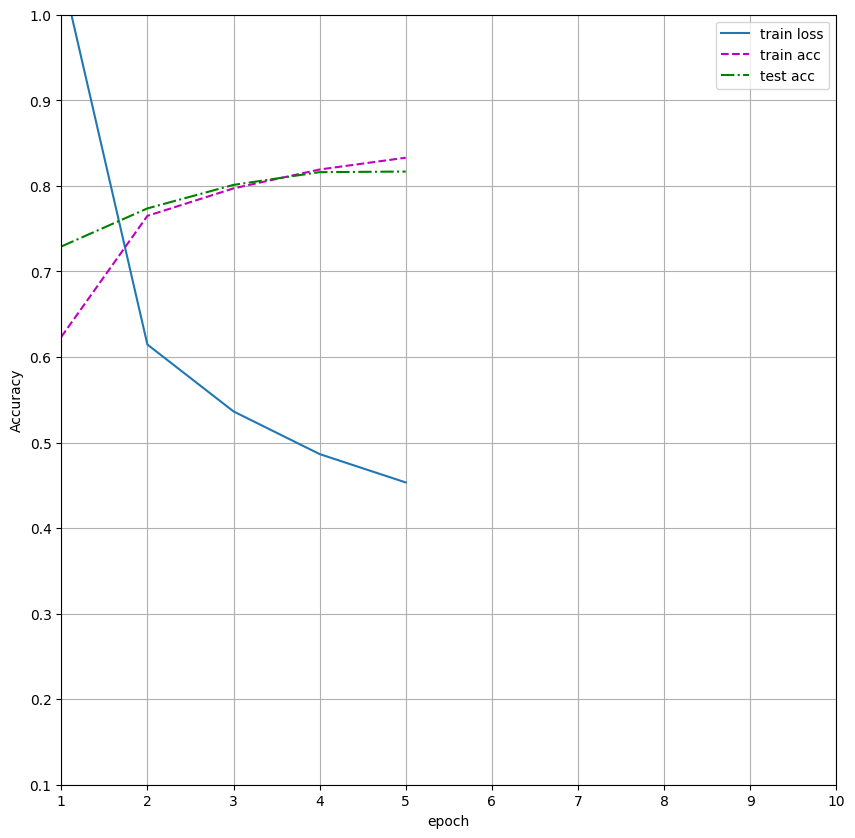

In [ ]:
lr = 0.001 # Possible choices: 0.00001, 0.0001, 0.001, 0.01, 0.1
num_epochs = 10 # # Possible choices: 500, 250, 50 -- inversely related to the learning rate
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

net.to(device)
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print('On:', device, 'Number of parameters to estimate/learn:', total_params)
train_loss, train_acc, test_acc = train_full (net, train_iter, test_iter, num_epochs, lr);
print(f"Training loss: {train_loss}\nTraining accuracy: {train_acc}\nTest accuracy: {test_acc}")

## Summary

* A CNN is a network that employs convolutional layers.
* In a CNN, we interleave convolutions, nonlinearities, and (often) pooling operations.
* In a CNN, convolutional layers are typically arranged to gradually decrease the spatial resolution of the representations while increasing the number of channels.
* In traditional CNNs, the representations encoded by the convolutional blocks are processed by one or more fully connected layers before emitting output.
* LeNet was arguably the first successful deployment of such a network.


# Assignment - Hyperparameter optimization

Starting from the LeNet5 as defined above in this notebook, try three of the following variations.

For each variation, start from the choices used in the code above and find the best option. Decide on the best choice as per test accuracy. Report the performances in one aggregated table.


* Hyperparameters to vary (Choose any three):
    1. Different optimization functions - https://pytorch.org/docs/stable/optim.html: SGD, Adam, RMSProp
    1. Batch_size = 32, 64, 128
    1. Convolution kernel sizes: 3, 5
    1. Number of output channels: (4, 12), (6, 16)
    1. Pooling: average pooling, maximum pooling.
    1. Activation function: softmax, ReLU, LeakyReLU
    1. Number of convolution layer: 1, 2, 3
    1. Number of fully connected layers: 1, 2
    1. (Learning rate, #epochs):  (0.0001, 100), (0.001, 50),  (0.01, 25),
    1. Initializations: (i) default, (ii) xavier_normal_, and (iii) kaiming_normal_


* In your report,

    1. Show the learning process by plotting the train and test accuracy using three figures. Create one figure for each of the choosen three variations. In the 11-th figure, plot the best case for each of the nine cases above. Give some thought on how to plot the curves so that they are distinguishable. Label the axes and use legends.

    2. Report the hyperparameter that results in the best test performance.

    3. Include one learning plot example of overfitting.

    4. Display the activations (outputs) of the first and second layer of LeNet for different inputs (e.g., sweaters and coats).


##Display activations from layers


In [ ]:
from skimage import io
from PIL import Image
import random
from torchvision import transforms

images, labels = next(iter(train_iter))
# ------------Read an image-----------------------------------
input_image = images[0]
input_image = input_image.squeeze().numpy()
input_image = Image.fromarray((input_image * 255).astype(np.uint8))
plt.imshow(input_image, cmap='gray')
plt.title('One image from Fashion MNIST');

In [ ]:
# -----------Normalize the image----------------------------
from torchvision import transforms
# The following creates an instance of transform sequence
preprocess = transforms.Compose([
    transforms.Resize(256), # resize to 256 by 256
    transforms.CenterCrop(224), # Crop a 224 by 224 sized image from the center
    transforms.ToTensor(),   # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalize pixel colod to have the ImageNet  mean and std
])
# Run the transform sequence on the image
input_image = input_image.convert('RGB')
input_tensor = preprocess(input_image)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale with 1 channel
])
input_tensor = transform(input_tensor)

# turn the 3D image array to a 4D one with 1 for mini-batch size, as expected by the model
input_batch = input_tensor.unsqueeze(0)

#--------------Create figure subplots---------------------------
fig, ax = plt.subplots(nrows=1, ncols=6)
fig2, ax2 = plt.subplots(nrows=1, ncols=16)
axes = [ax, ax2]
fig.set_size_inches (20, 10)
fig2.set_size_inches (20, 10)

#-------------Run the input through the layers-----------------
X = input_batch #torch.zeros (1, 3, 227, 227) # Sample image
k = 0
out_channels = [6, 16]
for layer in net:
    X = layer(X) # The output of a layer is the input to the next layer in the following iteration.
    if (layer.__class__.__name__ == 'Sigmoid'):
        for j in range(out_channels[k]):
          axes[k][j].imshow(X[0, j, :].detach().numpy(), 'gray')
          axes[k][j].set_title('L: %d, Ch: %d'%(k+1, j))
          axes[k][j].axis('off')
        k = k+1
    print(layer.__class__.__name__, 'output shape:\t', X.shape)
    if k > 1:
      break

# CIFAR - 10 Dataset

* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar



In [ ]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import numpy as np

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 64

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# train_iter = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# test_iter = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False, num_workers=2)
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0))) #reorder into (row, col, color)
#     plt.show()


# # get some random training images
# images, labels = next(iter(train_iter))

# # show images
# plt.figure(figsize=(10,10))
# imshow(torchvision.utils.make_grid(images))

# # print labels
# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))